# Modeling
**Input**: Data stored in PostgreSQL (selected features & targets)

**Output**: Trained model and its performance metrics

Finally we are ready to create our model.

The steps we want to follow are:
- Get the pivot Dataframe containing the targets and the features we have selected
- Shift the target
- Standardize data (in order to account for different value ranges across features)
- Apply PCA to further reduce the amount of features (speed up training while preserving information)
- Use cross validation to split data in multiple train-test sets in order to evaluate model performance
- Train model
- Test model & evaluate performance metrics

We want then to compare our "time agnostic" model with other "non-time agnostic" models that use also the time feature, like ARIMA/SARIMA/SARIMAX.

Our model tries to use only Exogenous (external) features, while other models use only Endogenous (internal) features (ARIMA/SARIMA) or a combination of Endogenous + Exogenous (SARIMAX).

- Target = Gold price
- Endogenous features = trend of gold price + seasonality of gold price
- Exogenous features = gdp growth + M3 money supply + unemployment + ...

Our thought process is that we want to understand how external features impact the return on an asset class, not how that asset class prices move with time. (We know that given enough time the nominal price rises, mainly due to inflation)
But it could be that prediction in the short term would be dependent also in endogenous features, so we are interested in knowing if that's the case.

Another way to try and remove non-stationarity would be indeed to adjust (in some way) all relevant features/measures to inflation. We didn't try this in this project, but would be an interesting following step to follow.


### 1. Get pivot Dataframe

In [1]:
# move to root to simplify imports
%cd ..

C:\Users\marco\PycharmProjects\portfolio-optimization


In [2]:
from portfolio_optimization.db import get_df_from_table
import pandas as pd

df = get_df_from_table("pivot")

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(by="date").set_index("date")
df = df.apply(pd.to_numeric)
df = df.asfreq('MS')
df_diff = df.diff()

df_diff.tail()

,feature1,feature10,feature101,feature105,feature114,feature121,feature124,feature13,feature130,feature134,...,target259,target260,target263,target265,target266,target267,target268,target55,target71,target82
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,NaN,-0.17593,-10.39436,131.0,-143.0,-8544.480899,-1.6,0.26659,0.01,20.0,...,-175.290039,-1334.699219,-574.490234,23.75,-55.26,-0.350545,-9.78,0.0000,0.0026,-0.33
2022-09-01,NaN,-0.22160,2.72030,-43.0,22.0,-210077.238012,1.6,0.21446,0.00,-2.0,...,-369.379883,-2784.919922,-1240.580078,90.00,-51.29,0.000000,-9.80,0.0062,0.0045,0.00
2022-10-01,NaN,-0.19432,4.00445,-39.0,-52.0,341875.642650,-0.6,0.10207,-0.02,11.0,...,286.359863,4007.439453,412.530273,-39.25,-26.55,0.607342,6.85,0.0046,0.0064,-4.89
2022-11-01,NaN,-0.15125,-3.15848,-7.0,-161.0,-160737.044341,-0.1,0.04968,0.02,-15.0,...,208.130127,1856.820312,479.849609,-86.75,135.33,NaN,-5.83,-0.0009,0.0061,NaN
2022-12-01,NaN,-0.11213,3.97545,-48.0,-14.0,163534.144075,-0.7,0.22090,0.02,6.0,...,-240.610107,-1442.519531,-1001.519531,-3.50,55.95,NaN,-0.50,-0.0027,0.0005,NaN


### 2. Shift the target
We want the model to predict future values of the target, so we need to "shift the targets".

This means that while now we have for each row in the Dataframe all the data corrisponding to that specific date, we want to shift the target so that, for the target column, in row n we have the value originally in row n+shift.

Let's choose a single target for the examples in this notebook. target266 represents gold futures prices.

Eg. (shift = 1)

In [3]:
target = "target266"

y = df_diff[[target]].dropna()
y.tail()

,target266
date,
2022-08-01,-55.26
2022-09-01,-51.29
2022-10-01,-26.55
2022-11-01,135.33
2022-12-01,55.95


In [4]:
target_df = y.shift(periods=-1)
target_df.tail()

,target266
date,
2022-08-01,-51.29
2022-09-01,-26.55
2022-10-01,135.33
2022-11-01,55.95
2022-12-01,NaN


### 3. Standardize data
We build a Dataframe X that contains the features data and than for each target we build a series y with the target shifted (we'll use shift = 1 in this notebook).

For Dataframe X we need to standardize data using StandardScaler from sklearn. This substitute each value with its z-score. That is (value - mean) / standard deviation.

In [5]:
feature_columns = [col for col in df_diff.columns if 'feature' in col]
X = df_diff[feature_columns].dropna()
X.tail()

,feature1,feature10,feature101,feature105,feature114,feature121,feature124,feature13,feature130,feature134,...,feature59,feature61,feature68,feature70,feature73,feature76,feature79,feature89,feature90,feature93
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01,0.000000,0.2905,-8.74155,85.0,94.0,75484.456688,0.1,0.31433,0.00,4.0,...,0.000000,0.28986,0.000638,-0.000709,0.000,215.0,-0.0103,-1.426308e+09,19183.0,0.000
2020-10-01,0.000000,0.2770,9.50484,69.0,-15.0,-159459.978754,0.0,0.14964,0.02,11.0,...,-0.002703,0.36348,0.000516,0.001120,0.000,-75.0,-0.0110,5.164804e+08,20112.0,85.507
2020-11-01,0.000000,0.1440,-9.93874,11.0,83.0,138804.273643,0.7,-0.04336,0.02,19.0,...,0.000000,0.40374,0.000778,-0.001442,0.000,-118.0,-0.0057,1.713586e+09,20100.0,0.000
2020-12-01,0.000000,0.1852,1.89173,110.0,48.0,1703.936091,0.0,0.00308,0.00,13.0,...,0.000000,0.42585,-0.000184,-0.004910,0.000,126.0,-0.0040,3.698740e+09,21264.0,0.000
2021-01-01,-0.007413,0.1467,4.37083,-49.0,113.0,-19270.162028,-0.1,0.00612,-0.05,21.0,...,0.000943,0.38164,-0.000027,0.002274,-273047.158,-47.0,-0.0020,-8.811221e+08,15872.0,59.479


In [6]:
from sklearn.preprocessing import StandardScaler

def standardize_features(df):
    scaled_features = StandardScaler().fit_transform(df.values)
    return pd.DataFrame(scaled_features, index=df.index, columns=feature_columns)
    
X = standardize_features(X)
X.tail()

,feature1,feature10,feature101,feature105,feature114,feature121,feature124,feature13,feature130,feature134,...,feature59,feature61,feature68,feature70,feature73,feature76,feature79,feature89,feature90,feature93
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01,0.022155,1.160086,-1.193071,0.865910,1.472606,0.531424,0.231300,1.424571,0.050286,0.185830,...,0.028226,0.741925,0.416832,-0.073704,0.112161,2.608883,-2.866655,-0.515460,2.232158,-0.154442
2020-10-01,0.022155,1.105684,1.293492,0.701708,-0.268291,-1.110187,0.019048,0.692818,0.717914,0.727688,...,-1.362098,0.930161,0.351771,0.157661,0.112161,-0.905204,-3.059615,0.093599,2.349977,5.356260
2020-11-01,0.022155,0.569728,-1.356220,0.106475,1.296919,0.973854,1.504813,-0.164722,0.717914,1.346956,...,0.028226,1.033100,0.491424,-0.166419,0.112161,-1.426258,-1.598633,0.468888,2.348456,-0.154442
2020-12-01,0.022155,0.735754,0.256000,1.122476,0.737916,0.015903,0.019048,0.041621,0.050286,0.882505,...,0.028226,1.089633,-0.021382,-0.605110,0.112161,1.530422,-1.130017,1.091227,2.496079,-0.154442
2021-01-01,-2.070076,0.580609,0.593844,-0.509284,1.776065,-0.130648,-0.193204,0.055128,-1.618784,1.501772,...,0.513122,0.976594,0.062194,0.303604,-10.365547,-0.565912,-0.578703,-0.344546,1.812242,3.678824


### 4. Apply PCA (Principal Component Analysis)
Principal Component Analysis (or PCA) uses linear algebra to transform the dataset into a compressed form.

Generally this is called a data reduction technique. A property of PCA is that you can choose the number of dimensions or principal component in the transformed result.

This is used to reduce the number of features in our model, while maintining their predictive power.

You can specify the number of components (features) you get at the end, but we don't want to compress too much as you can lose information if you do. You can use cross validation to find out the best number of components, but for this example we'll just use n_components = half the original number of features

In [7]:
X.tail()

,feature1,feature10,feature101,feature105,feature114,feature121,feature124,feature13,feature130,feature134,...,feature59,feature61,feature68,feature70,feature73,feature76,feature79,feature89,feature90,feature93
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01,0.022155,1.160086,-1.193071,0.865910,1.472606,0.531424,0.231300,1.424571,0.050286,0.185830,...,0.028226,0.741925,0.416832,-0.073704,0.112161,2.608883,-2.866655,-0.515460,2.232158,-0.154442
2020-10-01,0.022155,1.105684,1.293492,0.701708,-0.268291,-1.110187,0.019048,0.692818,0.717914,0.727688,...,-1.362098,0.930161,0.351771,0.157661,0.112161,-0.905204,-3.059615,0.093599,2.349977,5.356260
2020-11-01,0.022155,0.569728,-1.356220,0.106475,1.296919,0.973854,1.504813,-0.164722,0.717914,1.346956,...,0.028226,1.033100,0.491424,-0.166419,0.112161,-1.426258,-1.598633,0.468888,2.348456,-0.154442
2020-12-01,0.022155,0.735754,0.256000,1.122476,0.737916,0.015903,0.019048,0.041621,0.050286,0.882505,...,0.028226,1.089633,-0.021382,-0.605110,0.112161,1.530422,-1.130017,1.091227,2.496079,-0.154442
2021-01-01,-2.070076,0.580609,0.593844,-0.509284,1.776065,-0.130648,-0.193204,0.055128,-1.618784,1.501772,...,0.513122,0.976594,0.062194,0.303604,-10.365547,-0.565912,-0.578703,-0.344546,1.812242,3.678824


In [8]:
from sklearn.decomposition import PCA

pca_components = int(len(feature_columns)/2)

def apply_pca(df, pca_components):
    idx = df.index
    cols = [f"featurePCA{i + 1}" for i in range(pca_components)]

    df = PCA(n_components=pca_components).fit_transform(df)
    df = pd.DataFrame(df, columns=cols)
    df.index = idx
    return df

X = apply_pca(X, pca_components)
X.tail()

,featurePCA1,featurePCA2,featurePCA3,featurePCA4,featurePCA5,featurePCA6,featurePCA7,featurePCA8,featurePCA9,featurePCA10,...,featurePCA14,featurePCA15,featurePCA16,featurePCA17,featurePCA18,featurePCA19,featurePCA20,featurePCA21,featurePCA22,featurePCA23
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01,-2.745496,1.040712,-0.280796,-1.182478,0.717451,-0.798480,-0.089841,-1.364138,-1.007175,-0.002631,...,0.354802,-0.090801,0.674216,-0.445500,0.083797,0.533014,-1.057805,0.414112,0.037427,-1.098929
2020-10-01,-3.708758,0.103376,-3.592365,-1.350116,0.645448,0.571736,0.096293,-0.287686,0.885802,0.442318,...,-0.069714,-0.913831,0.355974,-1.365930,-0.913732,-1.635983,-0.915797,-2.257805,0.877320,1.481575
2020-11-01,-1.285159,0.462702,-0.690936,-0.636533,-0.140292,0.692448,-2.024825,0.073941,-0.311665,0.225890,...,-0.061725,-1.621092,1.290927,0.930309,1.218056,-0.084024,-1.408456,0.507656,-1.515466,-0.066619
2020-12-01,-2.454485,1.125457,-0.358885,-0.427437,0.171125,-0.112154,-0.927970,-1.357310,-0.678150,-0.920411,...,1.219297,0.734004,-0.063139,0.023628,1.086925,0.010149,-1.424477,-1.313970,-0.292049,-0.379492
2021-01-01,-8.550054,-9.451713,2.613227,0.304748,-4.362161,5.723074,-0.582111,-2.505005,2.633024,1.372732,...,1.514702,-3.837054,-3.204933,-1.605846,0.887556,1.041513,4.182417,0.362972,2.737875,0.438170


### 5. CV (cross validation)
To test a model the basic way is to just split the dataset in 2 (a large training set and a smaller test set). You train your model on the training set and that test its performance on the unseed test set.

A better way is to use cross validation, that is create multiple pairs of training+test and analyse the performance of the model in all the different pairings.

Usually this train-test split is just done randomly, but for time series data the process is less straighforward as we need to maintain the chronological order between the samples.

This can be done with a "rolling" training set and a test set coming chronologically after that training set. It's easier to look at a picture.

![convert notebook to web app](https://portfolio-ds-frontend.s3.eu-south-1.amazonaws.com/images/TimeSeriesSplit.png)

Below an example using 5 splits and test size of 12.

In [9]:
from sklearn.model_selection import TimeSeriesSplit

def get_X(df, cols):
    X = df[cols].dropna()
    X = standardize_features(X)
    pca_components = int(len(feature_columns)/2)
    X = apply_pca(X, pca_components)
    return X

tscv = TimeSeriesSplit(n_splits=5, test_size=12)
split = 1

X = get_X(df_diff, feature_columns)

for train_index, test_index in tscv.split(X):

    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    print(f"train {split}:", min(X_train.index), " - ", max(X_train.index))
    print(f"test {split}:", min(X_test.index), " - ", max(X_test.index))
    print()
    split += 1

train 1: 1995-02-01 00:00:00  -  2016-01-01 00:00:00
test 1: 2016-02-01 00:00:00  -  2017-01-01 00:00:00

train 2: 1995-02-01 00:00:00  -  2017-01-01 00:00:00
test 2: 2017-02-01 00:00:00  -  2018-01-01 00:00:00

train 3: 1995-02-01 00:00:00  -  2018-01-01 00:00:00
test 3: 2018-02-01 00:00:00  -  2019-01-01 00:00:00

train 4: 1995-02-01 00:00:00  -  2019-01-01 00:00:00
test 4: 2019-02-01 00:00:00  -  2020-01-01 00:00:00

train 5: 1995-02-01 00:00:00  -  2020-01-01 00:00:00
test 5: 2020-02-01 00:00:00  -  2021-01-01 00:00:00



### 6. Train model
For each step in the cross validation process we train the model on the train set and test it on the test set.

With testing we mean using the fitted model (trained) to predict values using the features in the test set. And then compare these predicted values with the actual values of the target in the test set.

To make sense of the result data and plot something meaningful we need to retransform the data into the original non-stationary form. We do this by transform the prediction values (which are the differences from the previous value) into a cumulative sum (now each value is the difference from the first value - not the previous) and add the first value.

Let's see an example using a LinearRegression model with the our example target (gold futures price).

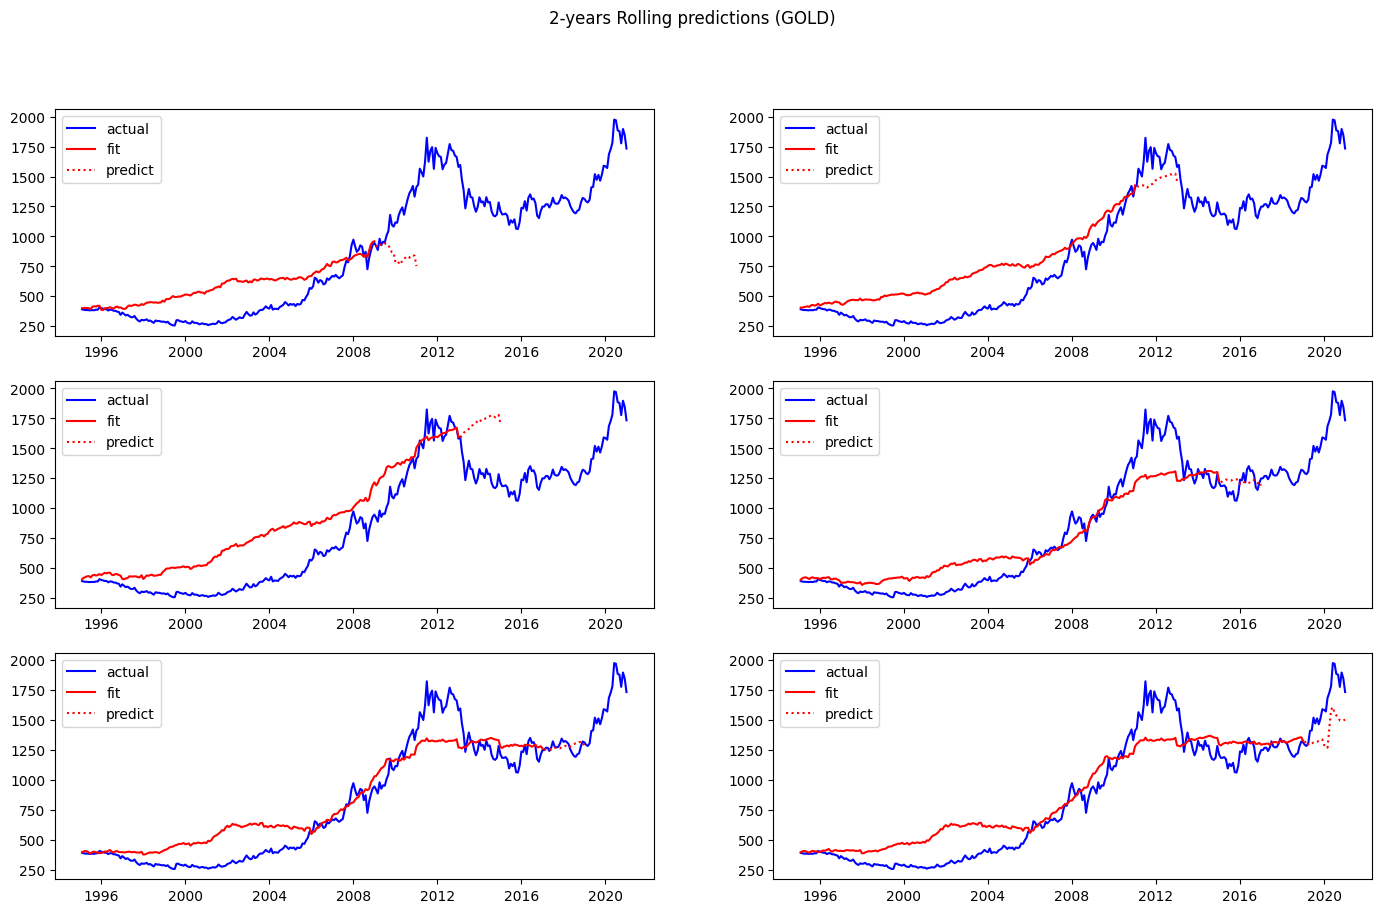

In [10]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

target = "target266"

# Features
X = get_X(df_diff, feature_columns)

# Non-stationary target
y_original = df[target].shift(-1).dropna()

# Stationary target (shifted)
y = df_diff[target].shift(-1).dropna()

# Align X, y and y_original in order to have the same rows without nulls
y, X = y.align(X, join='inner', axis=0)
y_original, y = y_original.align(y, join='inner', axis=0)

# Prepare our plot
fig = plt.figure(figsize=(17,10))
fig.suptitle("2-years Rolling predictions (GOLD)")
subplot_idx = 1

# Function to add subplot, it plots actual values, fitted values and predicted values
def prediction_subplot(y, y_train, y_test, y_fit, y_hat, rows, columns, idx):
    ax = fig.add_subplot(rows, columns, idx)
    plt.plot(y.index, y, color="blue", label="actual")
    plt.plot(y_train.index, y_fit, color="red", label="fit")
    plt.plot(y_test.index, y_hat, color="red", linestyle=":", label="predict")
    plt.legend()
    
# CV with 6 splits, each test set is 2-years long
tscv = TimeSeriesSplit(n_splits=6, test_size=24)

# let's store a list of predictions and tests to analyse performance later
y_hat_list = []
y_test_list = []

for train_index, test_index in tscv.split(X):
    
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    y_original_train, y_original_test = y_original.iloc[train_index], y_original.iloc[test_index]
    
    # Create and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Get non-stationary fitted values
    y_fit = model.predict(X_train)
    y_fit = y_fit.cumsum()
    y_fit += y_original_train[0]

    # Get non-stationary predicted values
    y_hat = model.predict(X_test)
    y_hat = y_hat.cumsum()
    y_hat += y_original_train[-1]
    
    # Store prediction and test to analyse performance later
    y_hat_list.append(y_hat)
    y_test_list.append(y_original_test)

    prediction_subplot(y_original, y_train, y_test, y_fit, y_hat, 3, 2, subplot_idx)
    subplot_idx += 1
    
plt.show()

### 7. Evaluate model performance
There are many different metrics we can use to measure the goodness of a time series prediction model, such as:
- MPE: Mean Percentage Error, measures the average prediction error in % terms
- MAPE: Mean Absolute Percentage Error, as MPE but absolute values
- ME: Mean Error, measures the average prediction error in the same unit of measure as the target
- MAE: Mean Absolute Error, as ME but absolute values
- RMSE: Root Mean Squared Error, squared root of the average squared prediction error
- CORR: Pearson correlation between predicted values and actual values

Let's see an example using the values we have from the last loop of the CV we did in the cell above.

In [11]:
import numpy as np

def forecast_accuracy(forecast, actual):
    
    mae = np.mean(np.abs(forecast - actual))  # MAE
    rmse = np.mean((forecast - actual) ** 2) ** .5  # RMSE
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    
    me = np.mean(forecast - actual)  # ME
    mpe = np.mean((forecast - actual) / actual)  # MPE

    corr = np.corrcoef(forecast, actual)[0, 1]  # corr

    return ({'mae': mae, 'rmse': rmse, 'mape': mape, 'me': me, 'mpe': mpe,  'corr': corr})

def cv_metrics(y_hat_list, y_test_list):
    performance_df = []
    for i in range(len(y_hat_list)):
        performance_df.append(forecast_accuracy(y_hat_list[i], y_test_list[i]))
    performance_df = pd.DataFrame(performance_df)
    return performance_df
    
cv_metrics(y_hat_list, y_test_list)

,mae,rmse,mape,me,mpe,corr
0,295.388491,360.556204,0.236879,-291.355337,-0.232329,-0.729440
1,180.101987,199.825801,0.107164,-180.101987,-0.107164,0.312375
2,418.408637,441.508767,0.332269,417.941332,0.331976,-0.733845
3,79.193570,92.477370,0.067370,22.181504,0.023598,-0.554232
4,39.916872,51.021453,0.031761,5.165737,0.005284,-0.241093
5,233.963977,264.230690,0.136750,-230.846730,-0.134336,0.864385


Each cross validation set has its own performance metrics. Let's compute the average and standard deviation to have an overall performance and robustness of the model.

In [12]:
cv_metrics(y_hat_list, y_test_list).agg(["mean","std"])

,mae,rmse,mape,me,mpe,corr
mean,207.828922,234.936714,0.152032,-42.835913,-0.018828,-0.180309
std,140.145516,151.434917,0.112751,258.765933,0.196047,0.645846


Let's interpret these results:
- MAE: we got an average error of 205 in our predictions
- RMSE: similar to MAE, gives more weight to big errors
- MAPE: we got an average error of 15% in our predictions
- ME: we are underestimating in our predictions by about 38 points overall
- MPE: we are underestimating in our preddictions by about 1.7% overall
- CORR: we have a negative correlation between predicted and actual value, which is not very good

### Let's now put all together!

We want to train and test a model for each target, so we need to cycle through them and collect performance metrics.
In this example we'll cycle through a couple targets.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

feature_columns = [col for col in df_diff.columns if 'feature' in col]
target_columns = [col for col in df_diff.columns if 'target' in col]

# Limit to 2 targets for this example
target_columns = target_columns[:2]

pca_components = int(len(feature_columns)/2)

# list to store model performance
performance = []

for target in target_columns:
        
    X = df_diff[feature_columns].dropna()
    y = df_diff[target].shift(-1).dropna()
    y_original = df[target].shift(-1).dropna()
    
    y, X = y.align(X, join='inner', axis=0)
    y_original, y = y_original.align(y, join='inner', axis=0)   
    
    for train_index, test_index in tscv.split(X):
    
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_original_train, y_original_test = y_original.iloc[train_index], y_original.iloc[test_index]
    
        # a Pipeline object allows us to specify several steps to be executed sequentially
        # in this case we want to standardize features and apply PCA
        # last step in a pipeline must be an estimator
        pipe = Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("pca", PCA(n_components=pca_components)),
            ("model", LinearRegression())
        ])
        pipe.fit(X_train, y_train)
        
        y_hat = pipe.predict(X_test)
        y_hat = y_hat.cumsum()
        y_hat += y_original_train[-1]
        
        p_ = forecast_accuracy(y_hat, y_original_test)
        p_["target"] = target
        performance.append(p_)
        
p_df = pd.DataFrame(performance)
p_df

,mae,rmse,mape,me,mpe,corr,target
0,243.880321,252.613676,0.383923,-243.880321,-0.383923,0.746288,target254
1,81.093570,90.103575,0.102805,74.850787,0.095509,0.622446,target254
2,106.752652,119.104690,0.093399,-106.752652,-0.093399,0.795353,target254
3,72.770762,90.779561,0.063394,50.929662,0.047271,0.826217,target254
4,88.434954,112.222459,0.055905,-75.169139,-0.046106,0.717297,target254
5,517.389189,749.793767,0.322333,512.234462,0.319228,0.552717,target254
6,0.568378,0.653368,0.180286,0.563523,0.178732,0.727861,target256
7,2.063959,2.217816,1.121271,2.063959,1.121271,-0.779816,target256
8,0.364747,0.438362,0.155839,-0.092397,-0.015306,-0.087059,target256
9,0.498065,0.596426,0.236267,-0.498065,-0.236267,0.275681,target256


To compare results across different features our best bet are the metrics that compute % error (MAPE, MPE) or the correlation metric.

What we could now do is trying different regression models (instead of the basic LinearRegression), and also use cross-validation for hyperparameter-tuning. Each model has many hyperparameters that can be tuned and a way to do this is to try different combinations of hyperparameters and compare the performance.

There are sklearn objects designed specifically with this goal in mind, like GridSearchCV and many others.
https://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers

This is a pretty much a big chore, where the goal line is dependent just on computing power and patience.
We'll just give an example of how to do it below, without entering in too much detail.

In [14]:
def hyperparameter_tuning(X, y):
    pipe = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_components)),
        ("model", LinearRegression())
    ])
    
    param_grid = [
        {
            "scaler":[StandardScaler(), "passthrough"],
            "pca": [PCA(n_components=5), PCA(n_components=10), "passthrough"],
            "model": [SGDRegressor()],
            "model__learning_rate": ['invscaling', 'adaptive'],
            "model__l1_ratio": [0.15, 0.5],
        },
        {
            "scaler":[StandardScaler(), "passthrough"],
            "pca": [PCA(n_components=5), PCA(n_components=10), "passthrough"],
            "model": [MLPRegressor()],
            "model__hidden_layer_sizes": [(100,), (10,), (50,3,)],
            "model__solver": ["lbfgs", "sgd", "adam"],
        },
        
        ...
    
    ]
    
    cv = GridSearchCV(pipe, param_grid, 
            cv=TimeSeriesSplit(n_splits=6, test_size=24))
    
    cv.fit(X, y)
    return pd.DataFrame(cv.cv_results_)

What we are really interested in is the performance difference of our model with other "time-dependent" models, that make use of the time variable to help them predict.
## ARIMA
ARIMA stands for AutoRegressive Integrated Moving Average. It is a model that uses past values to predict future values.

ARIMA Components:
- AR (Autoregression), model uses lag values (past values) to forecast
- I (Integrated), model apply differencing to make data stationary
- MA (Moving average), model uses lagged forecast errors to forecast

ARIMA Parameters:
- p, order of AR, number of lags of Y to be used as features
- q, order of MA, number of lagged forecast errors to be used as features
- d, differencing period, number of differencing needed to make data stationary

Let's start analysing data to find the correct parameters for our ARIMA model.

In [15]:
target = "target266" # Let's continue using Gold
y = df[[target]].dropna()
y.tail()

,target266
date,
2022-08-01,1710.96
2022-09-01,1659.67
2022-10-01,1633.12
2022-11-01,1768.45
2022-12-01,1824.40


To find d we need to choose how many times we need to differentiate our data in order for it to become stationary.

We can use the ADFuller test we have already seen in the EDA step.

In [16]:
from statsmodels.tsa.stattools import adfuller

def d_arima(series):
    
    d = 0
    tmp = series.copy()

    while(d < 5):
        
        # take p-value from ADFuller test
        p_value = adfuller(tmp)[1]
        
        # if data is stationary, stop
        if p_value < 0.05:
            return d
        
        # else take another differencing step
        else:
            tmp = tmp.diff().dropna()
            d += 1

    return d

d_arima(y)

1

We get d = 1, one differencing is enough to make data stationary.

We can find the value for q parameter by inspecting the ACF plot.

The autocorrelation function ACF computes the correlation between the actual values and the lagged values. So for lag=1, the correlation between the value and the previous one. For lag=2, the correlation between the value and the value 2 months before, and so on.

We choose q as the last significant autocorrelated lag.

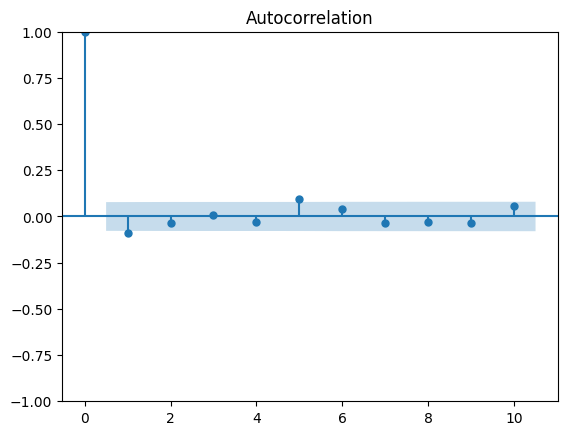

In [17]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(y.diff().dropna(), lags=10)
plt.show()

In this case no lag is significant, so we choose q = 0. We could make a case for q=1 because the point is pretty much at the significance level, but when in doubt better choose the lower value.

We can find the value for p parameter by inspecting the PACF plot.

The difference between autocorrelation function ACF and partial PACF is that in ACF we have the correlation between the actual value with every lag, while in PACF we have only the "incremental autocorrelation".

The partial autocorrelation for a lag is the correlation that cannot be explained by shorter lags.

We choose p as the last significant partial autocorrelated lag.

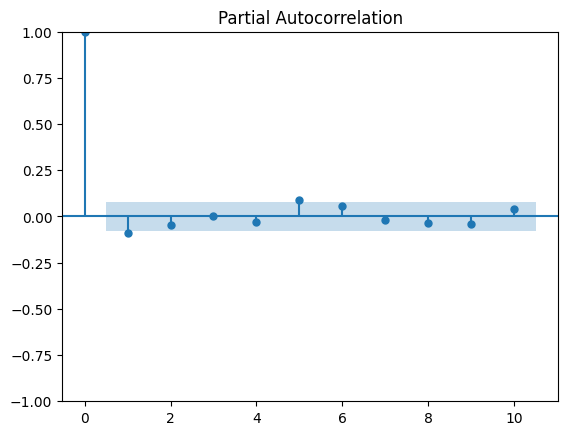

In [18]:
import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(y.diff().dropna(), lags=10, method="ywm")
plt.show()

In this case no lag is significant, so we choose p = 0. We could make a case for p=1 because the point is pretty much at the significance level, but when in doubt better choose the lower value.

ARIMA, being only based on the target data and no other exogenous features can predict out-of-sample. Let's try this.

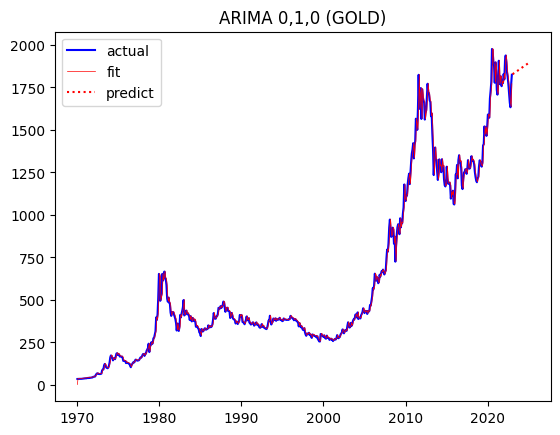

2024-08-01    1880.841561
2024-09-01    1883.663639
2024-10-01    1886.485717
2024-11-01    1889.307795
2024-12-01    1892.129873
Freq: MS, Name: predicted_mean, dtype: float64

In [19]:
from statsmodels.tsa.arima.model import ARIMA

p = 0
d = 1
q = 0

model = ARIMA(y, order=(p, d, q), trend=[0, 1]).fit()
fc = model.forecast(24)

plt.title("ARIMA 0,1,0 (GOLD)")
plt.plot(y.index, y, color="blue", label="actual")
plt.plot(y.index, model.fittedvalues, color="red", linewidth=0.5, label="fit")
plt.plot(fc.index, fc, color="red", linestyle=":", label="predict")
plt.legend()
plt.show()

fc.tail()

An easier way to compute the parameters for ARIMA is to use another library that has already a method to automatically compute the optimal parameters based on the data.

Let's see how.

In [20]:
import pmdarima as pm

model = pm.auto_arima(y, test='adf', seasonal=False)

order = model.get_params()["order"]
print(f"p:{order[0]}, d:{order[1]}, q:{order[2]}")

p:0, d:1, q:1


Auto ARIMA choose q=1, the only difference with our "manual" parameters.

Let's use the model to predict.

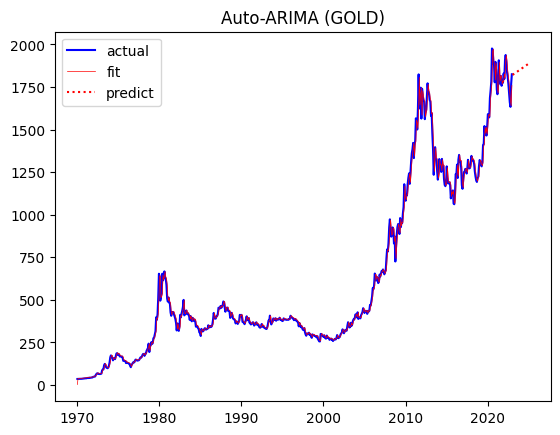

2024-08-01    1874.152854
2024-09-01    1876.966730
2024-10-01    1879.780607
2024-11-01    1882.594483
2024-12-01    1885.408359
Freq: MS, dtype: float64

In [21]:
fc = model.predict(n_periods=24)

plt.title("Auto-ARIMA (GOLD)")
plt.plot(y.index, y, color="blue", label="actual")
plt.plot(y.index, model.fittedvalues(), color="red", linewidth=0.5, label="fit")
plt.plot(fc.index, fc, color="red", linestyle=":", label="predict")
plt.legend()
plt.show()

fc.tail()

We get similar predicted values.

Let's see the performance metrics for this model (we have to do cross validation in order to do that and compare with our previous model).

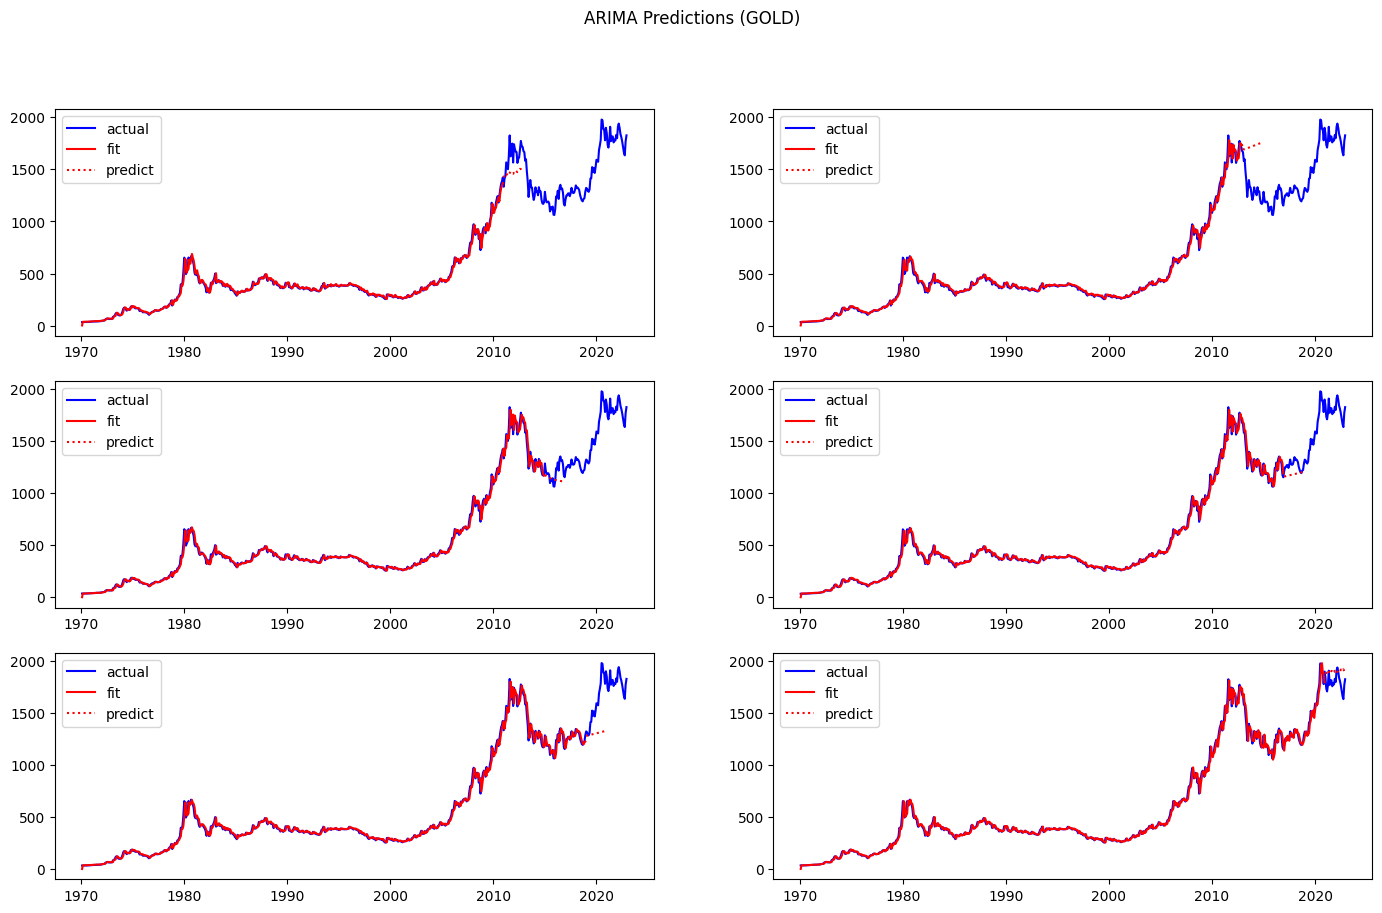

,mae,rmse,mape,me,mpe,corr
mean,189.405724,217.699568,0.129810,-15.233250,-0.000260,0.048622
std,126.921998,138.290831,0.097551,239.423207,0.170062,0.642309


In [22]:
# CV with 6 splits, each test set is 2-years long
tscv = TimeSeriesSplit(n_splits=6, test_size=24)

# Prepare our plot
fig = plt.figure(figsize=(17,10))
fig.suptitle("ARIMA Predictions (GOLD)")
subplot_idx = 1

# let's store a list of predictions and tests to analyse performance later
y_hat_list = []
y_test_list = []

for train_index, test_index in tscv.split(y):
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = pm.auto_arima(y_train, test='adf', seasonal=False)
    y_hat = model.predict(n_periods=24)
    
    # Store prediction and test to analyse performance later
    y_hat_list.append(y_hat)
    y_test_list.append(y_test.iloc[:,0])
       
    prediction_subplot(y, y_train, y_test, model.fittedvalues(), y_hat, 3, 2, subplot_idx)
    subplot_idx += 1

plt.show()

cv_metrics(y_hat_list, y_test_list).agg(["mean","std"])

This is very similar to our original model, at least for this specific target.

Let's try to add seasonality to the model to see if we can improve performance.

### SARIMA
SARIMA stands for **Seasonal** AutoRegressive Integrated Moving Average.

It uses the same concepts as ARIMA (uses past values to forecast future values), but also takes into account any seasonality patterns. 

So, it is more powerful than ARIMA in forecasting complex data spaces containing cycles.

SARIMA has the same p,q,d parameters as ARIMA, plus 4 additional ones.

SARIMA additional parameters:
- m, number of time steps for a single seasonal period
- P, order of seasonal AR, number of (lags * m) of Y to be used as features
- Q, order of MA, number of (lagged forecast errors * m) to be used as features
- D, differencing period, number of differencing needed to make data stationary (shift=m)

We can use auto_arima to quickly build the model, passing Seasonal=True and a value for m that reflects the use case.

In this case we use m=12, as we assume an annual seasonality.

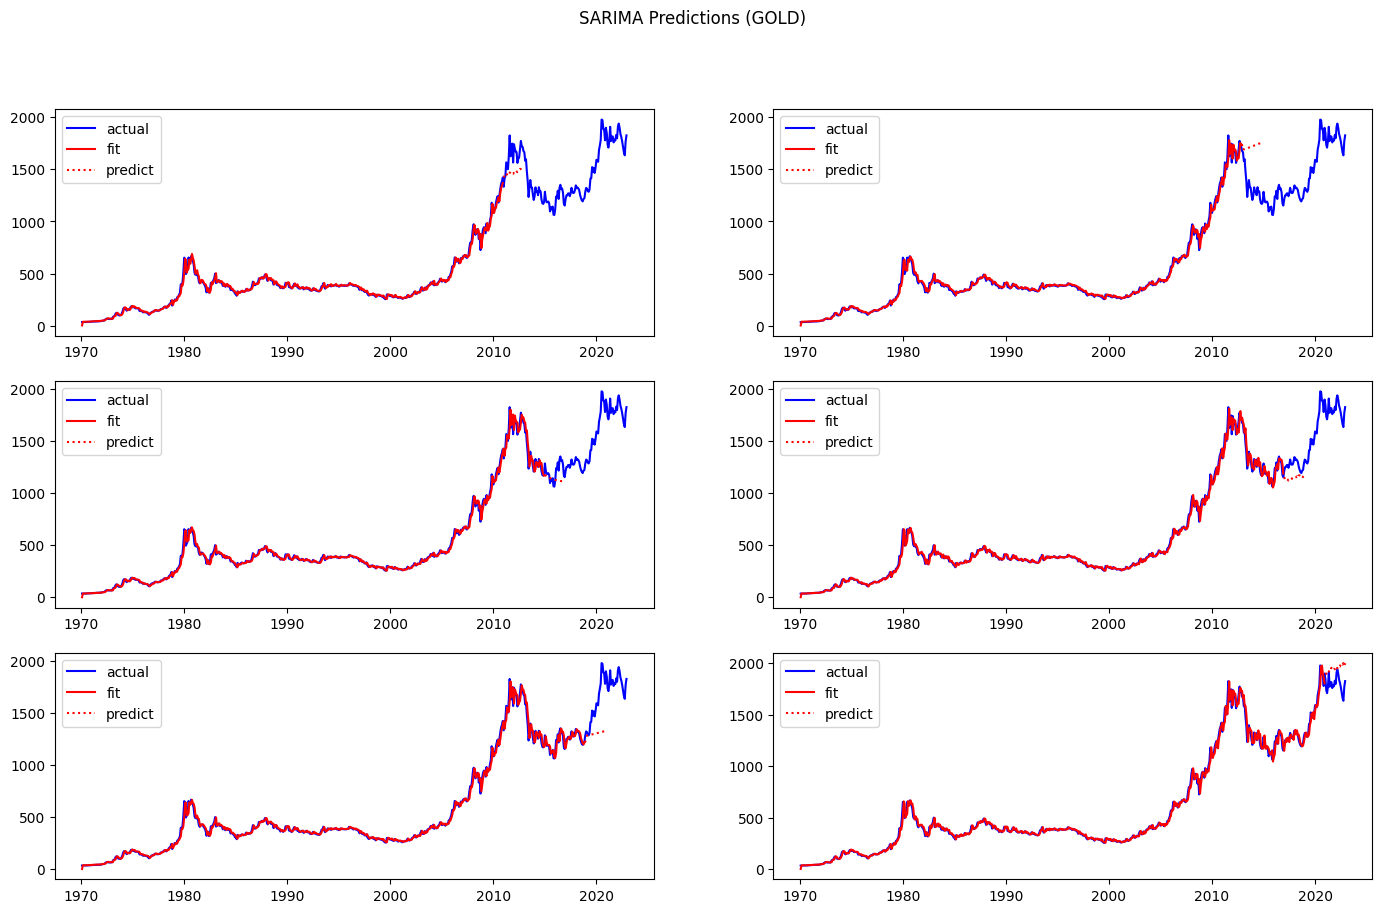

,mae,rmse,mape,me,mpe,corr
mean,202.762364,231.101942,0.138686,-13.125303,-0.000462,0.021126
std,117.012535,127.782182,0.091303,247.971861,0.175141,0.654994


In [23]:
# CV with 6 splits, each test set is 2-years long
tscv = TimeSeriesSplit(n_splits=6, test_size=24)

# Prepare our plot
fig = plt.figure(figsize=(17,10))
fig.suptitle("SARIMA Predictions (GOLD)")
subplot_idx = 1

# let's store a list of predictions and tests to analyse performance later
y_hat_list = []
y_test_list = []

for train_index, test_index in tscv.split(y):
    
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = pm.auto_arima(y_train, test='adf', m=12, seasonal=True)
    y_hat = model.predict(n_periods=24)
    
    # Store prediction and test to analyse performance later
    y_hat_list.append(y_hat)
    y_test_list.append(y_test.iloc[:,0])
    
    prediction_subplot(y, y_train, y_test, model.fittedvalues(), y_hat, 3, 2, subplot_idx)
    subplot_idx += 1

plt.show()

cv_metrics(y_hat_list, y_test_list).agg(["mean","std"])

We get similar results as ARIMA, due to the fact that probably there is no annual seasonality for gold.

A way to make ARIMA more powerful is to add exogenous features, with SARIMAX.

### SARIMAX
SARIMAX stands for Seasonal AutoRegressive Integrated Moving Average with **Exogenous** factors.

It is similar to SARIMA with the difference that we can also pass Exogenous features to the model.

Let's see it in action.

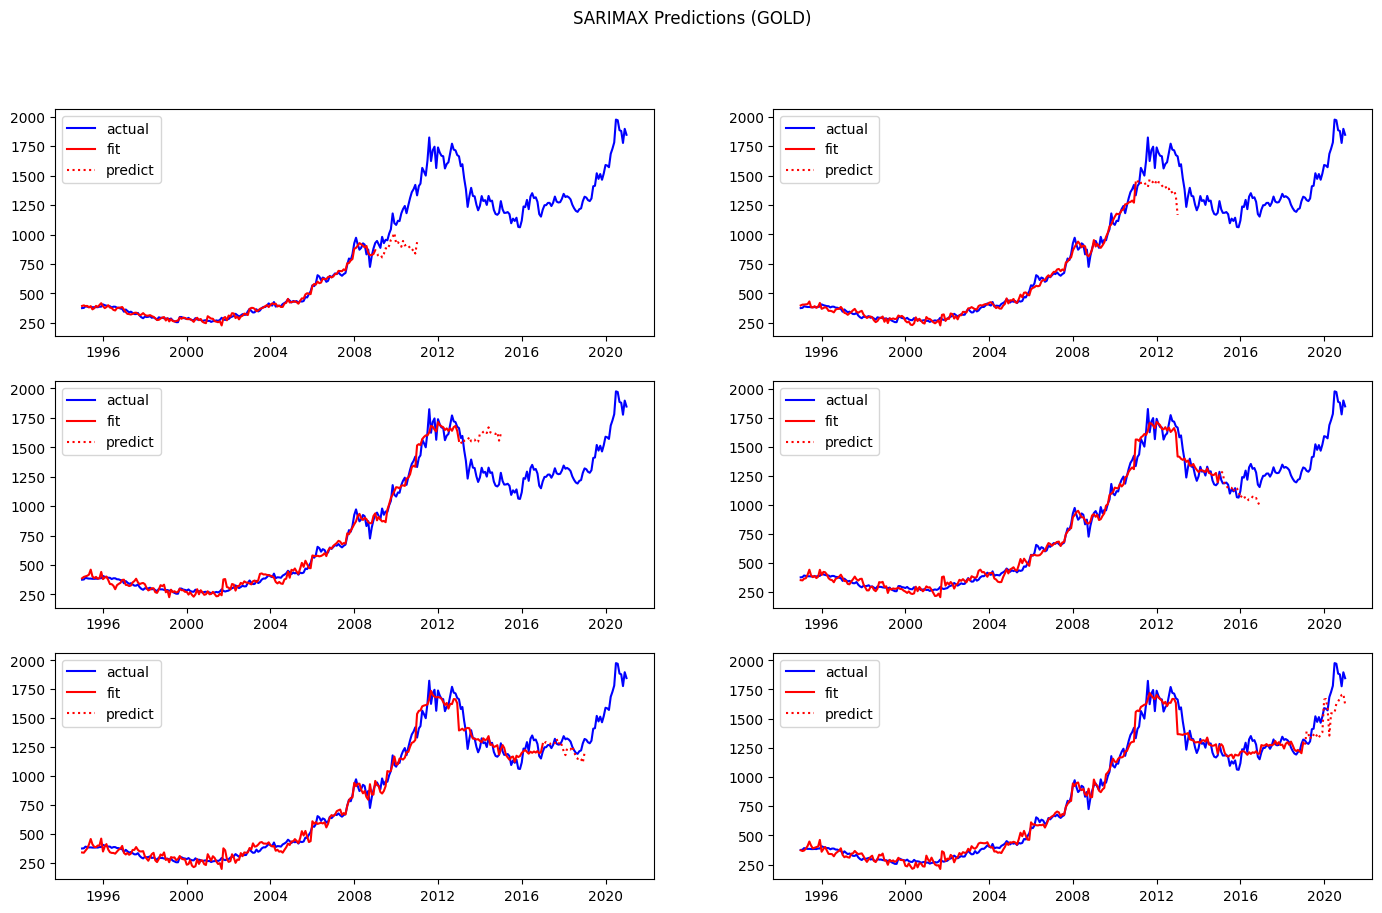

,mae,rmse,mape,me,mpe,corr
mean,182.306117,211.993961,0.132909,-72.814019,-0.046082,0.045770
std,86.689802,90.613138,0.069438,190.466664,0.144799,0.466993


In [24]:
X = get_X(df, feature_columns)

target = "target266" # Let's continue using Gold
y = df[[target]].dropna()

y, X = y.align(X, join="inner", axis=0)

# CV with 6 splits, each test set is 2-years long
tscv = TimeSeriesSplit(n_splits=6, test_size=24)

# Prepare our plot
fig = plt.figure(figsize=(17,10))
fig.suptitle("SARIMAX Predictions (GOLD)")
subplot_idx = 1

# let's store a list of predictions and tests to analyse performance later
y_hat_list = []
y_test_list = []

for train_index, test_index in tscv.split(y):
    
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = pm.auto_arima(y_train, X=X_train, test='adf', m=12, seasonal=True)
    y_hat = model.predict(n_periods=24, X=X_test)
    
    # Store prediction and test to analyse performance later
    y_hat_list.append(y_hat)
    y_test_list.append(y_test.iloc[:,0])
    
    prediction_subplot(y, y_train, y_test, model.fittedvalues(), y_hat, 3, 2, subplot_idx)
    subplot_idx += 1

plt.show()

cv_metrics(y_hat_list, y_test_list).agg(["mean","std"])

Results are slightly better if you take into consideration exogenous variables and overall a little better than our model than did not take into consideration endogenous features (aka past values of the target).

Of course our model could also be better tuned with hyperparameters optimization.

While it looks like most of the prediction power comes from exogenous features (like we first thought), it seems that also endogenous features are useful in term of improving our prediction accuracy.

Let's try to build a new model based on this new information.

## Hybrid Models
We want now to integrate endogenous features into our model (aka past values), so we better start by defining the components of a time series.

There are 4 main components of a time series:
- Trend - The trend component refers to the overall direction of the data over time. This can be an increasing, decreasing or a stationary trend
- Seasonality - Seasonality refers to the periodic fluctuations in the data that occur at regular intervals. These fluctuations could be daily, weekly, monthly, quarterly or yearly
- Cyclical - The cyclical component of a time series refers to the long-term, non-seasonal fluctuations that occur over an extended period of time. These fluctuations are not periodic, but they tend to be related to business cycles, economic cycles or other long-term trends
- Random - The random component, also known as the residual, refers to the unpredictable fluctuations in the data that are not explained by the other components

Different models are better at identifying specific components of a time series, so we can build a hybrid model that makes 2 or models work together to give us the best prediction.

Let's start with the trend component.

Here we have a choice to make. The polynomial order of the trend line to fit. The higher the polynomial, the better fit we will get on training data, but the more likely to overfit the model and get poor results on test data.

For this example we choose 2.

In [25]:
from statsmodels.tsa.deterministic import DeterministicProcess

target = "target266" # Let's continue using Gold
y = df[[target]].dropna()

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=2,
    drop=True
)

X_dp = dp.in_sample()
X_dp

,const,trend,trend_squared
date,,,
1970-02-01,1.0,1.0,1.0
1970-03-01,1.0,2.0,4.0
1970-04-01,1.0,3.0,9.0
1970-05-01,1.0,4.0,16.0
1970-06-01,1.0,5.0,25.0
...,...,...,...
2022-08-01,1.0,631.0,398161.0
2022-09-01,1.0,632.0,399424.0
2022-10-01,1.0,633.0,400689.0


DeterministicProcess build a features Dataframe entirely based on the time variable, with the polynomial order we specify.

Let's use this simple features to predict.

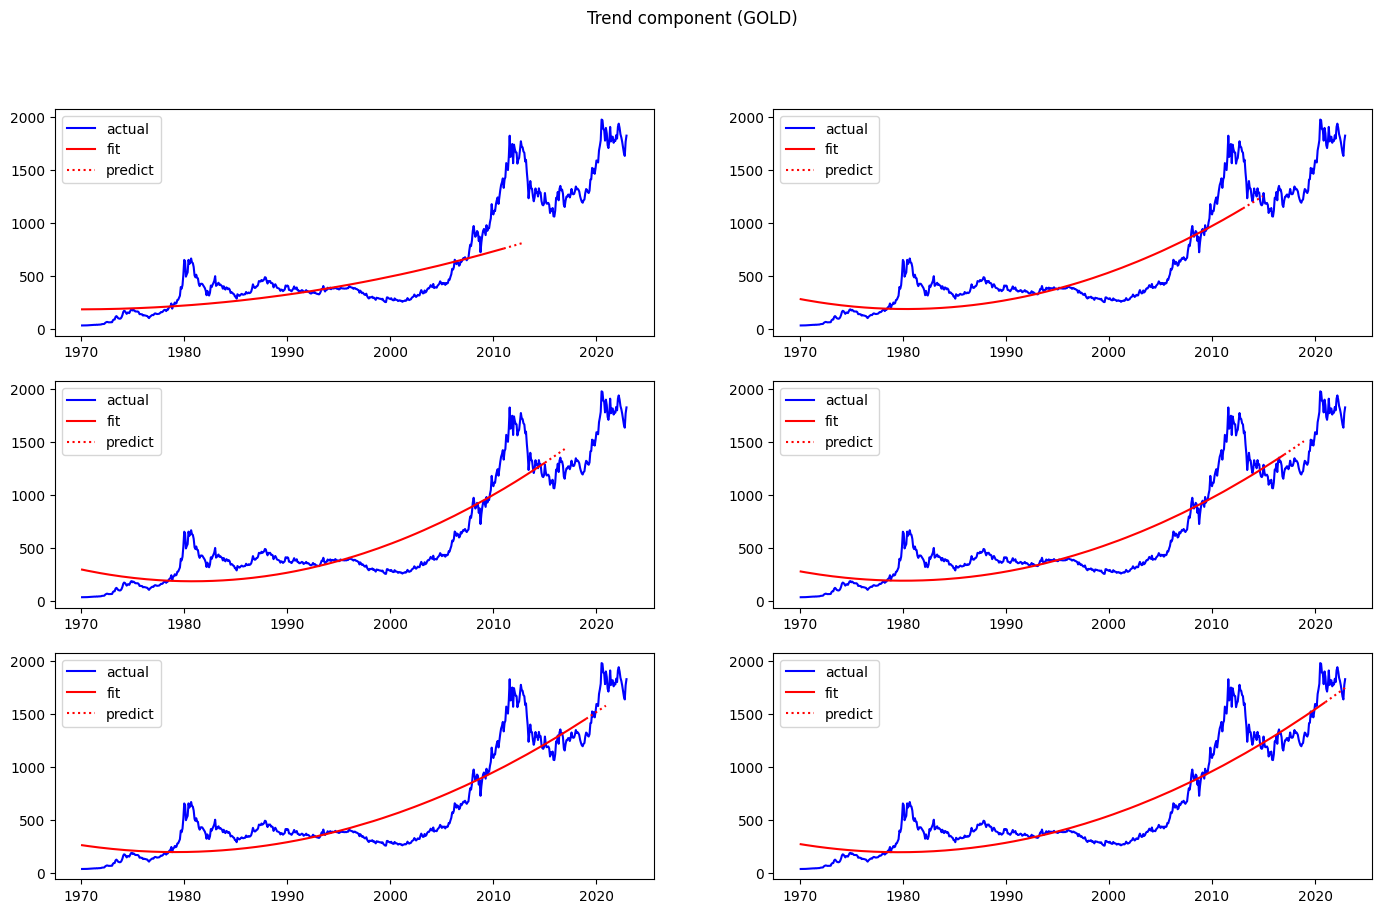

,mae,rmse,mape,me,mpe,corr
mean,270.168186,294.814687,0.178213,-136.888710,-0.069351,0.140994
std,278.160095,269.889490,0.166198,369.717669,0.239669,0.626751


In [26]:
# CV with 6 splits, each test set is 2-years long
tscv = TimeSeriesSplit(n_splits=6, test_size=24)

# Prepare our plot
fig = plt.figure(figsize=(17,10))
fig.suptitle("Trend component (GOLD)")
subplot_idx = 1

# let's store a list of predictions and tests to analyse performance later
y_hat_list = []
y_test_list = []

for train_index, test_index in tscv.split(y):
    
    X_train, X_test = X_dp.iloc[train_index, :], X_dp.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_hat = model.predict(X_test)
       
    # Store prediction and test to analyse performance later
    y_hat_list.append(y_hat.ravel())
    y_test_list.append(y_test.iloc[:,0])
    
    prediction_subplot(y, y_train, y_test, model.predict(X_train), y_hat, 3, 2, subplot_idx)
    subplot_idx += 1

plt.show()
cv_metrics(y_hat_list, y_test_list).agg(["mean","std"])

As you can see the model is pretty basic at this point, we still need to add seasonality and cycle components.

Let's now add seasonality component.

In [27]:
target = "target266" # Let's continue using Gold
y = df[[target]].dropna()

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=2,
    drop=True,
    seasonal=True,
)

X_dp = dp.in_sample()
X_dp

,const,trend,trend_squared,"s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)","s(10,12)","s(11,12)","s(12,12)"
date,,,,,,,,,,,,,,
1970-02-01,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-03-01,1.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-04-01,1.0,3.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-05-01,1.0,4.0,16.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970-06-01,1.0,5.0,25.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,1.0,631.0,398161.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-09-01,1.0,632.0,399424.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-10-01,1.0,633.0,400689.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


This add new dummy features representing seasonality.

Let's try to predict now.

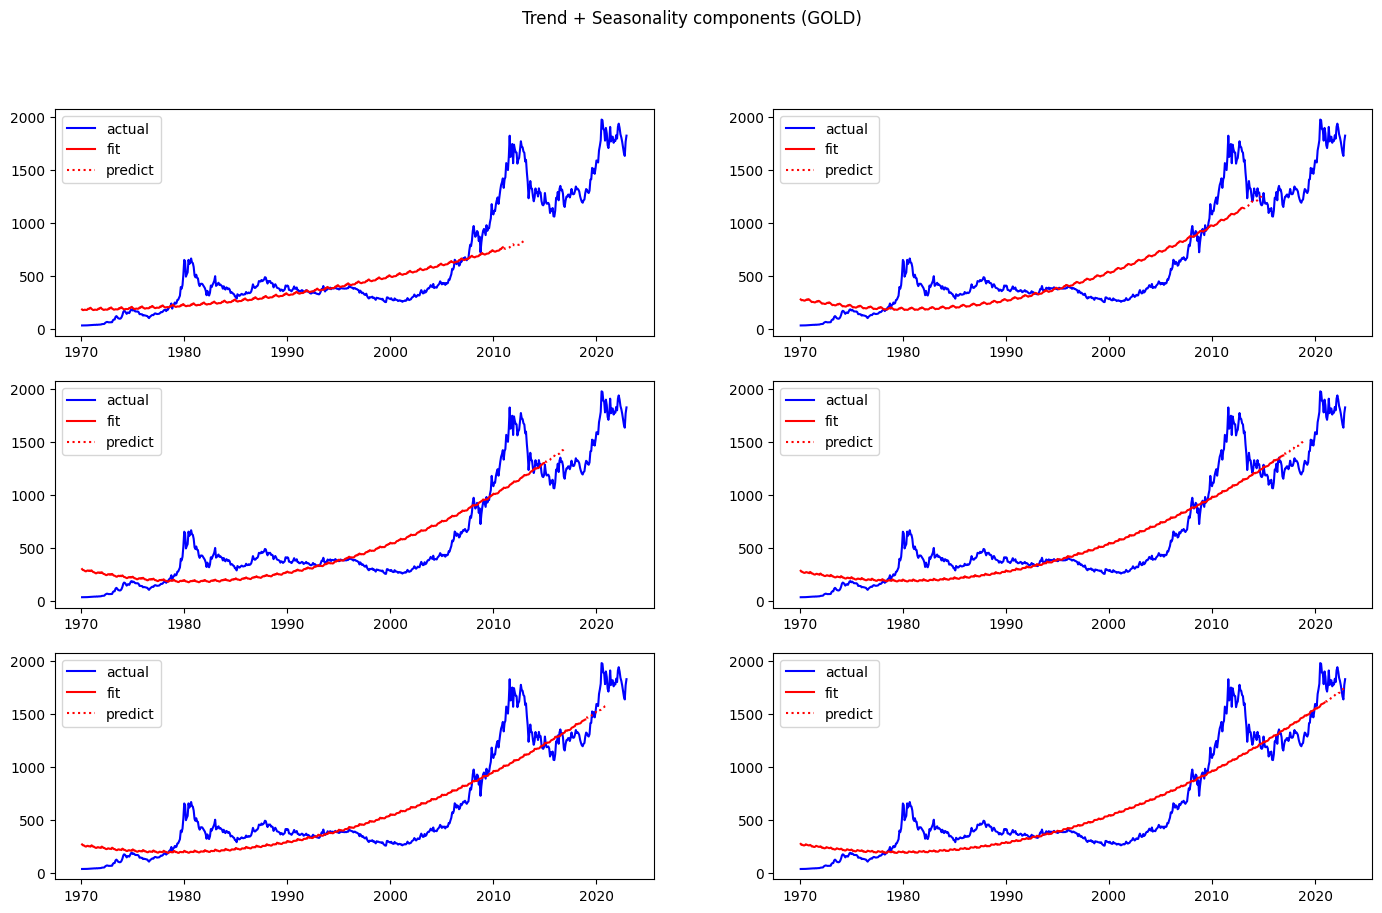

,mae,rmse,mape,me,mpe,corr
mean,270.941128,295.632154,0.178786,-136.882996,-0.069288,0.123848
std,277.843056,269.536810,0.165973,369.825610,0.239783,0.622535


In [28]:
# CV with 6 splits, each test set is 2-years long
tscv = TimeSeriesSplit(n_splits=6, test_size=24)

# Prepare our plot
fig = plt.figure(figsize=(17,10))
fig.suptitle("Trend + Seasonality components (GOLD)")
subplot_idx = 1

# let's store a list of predictions and tests to analyse performance later
y_hat_trend_list = []
y_fit_trend_list = []
y_test_list = []

for train_index, test_index in tscv.split(y):
    
    X_train, X_test = X_dp.iloc[train_index, :], X_dp.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_fit = model.predict(X_train)
    y_hat = model.predict(X_test)
       
    # Store prediction and test to analyse performance later
    y_fit_trend_list.append(y_fit.ravel())
    y_hat_trend_list.append(y_hat.ravel())
    y_test_list.append(y_test.iloc[:,0])
    
    prediction_subplot(y, y_train, y_test, model.predict(X_train), y_hat, 3, 2, subplot_idx)
    subplot_idx += 1

plt.show()
cv_metrics(y_hat_trend_list, y_test_list).agg(["mean","std"])

This add little information because as we saw before our data has little seasonality.

Finally let's add cyclical component using a second model (in this case we'll use a different model - GradientBoostingRegressor, but we could also use another LinearRegression model).

We want the target to be the residuals of the previous model, because we want to fit this second model just on the errors of the first one. This is the way to combine the strengths of the 2 models.

The features in this case will be the shifted target (in this case we call this lag because we are shifting in the opposite direction). For example, with lag=1 the row for march 2022 will contain the target value on feb 2022 as a feature.

First thing we need to choose how many lags to use for our target, and we can do this in a similar way as we did for choosing the ARIMA parameters.

Plotting the PACF we can see how many lags add information about autocorrelation.

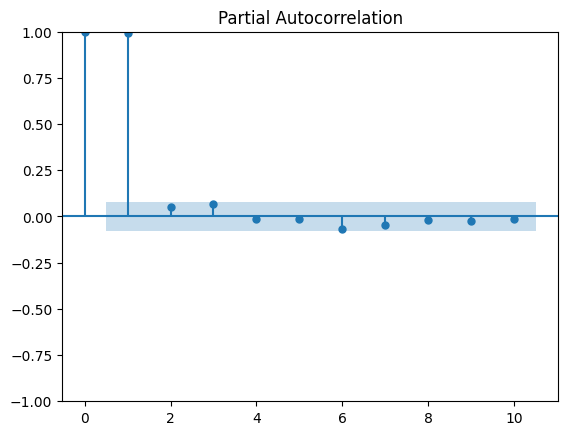

In [29]:
import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(y.dropna(), lags=10, method="ywm")
plt.show()

We can see that pretty much all autocorrelation is already explained with the first lags, and the subsequential ones add little to no information.

So for this target we can use lags = 1

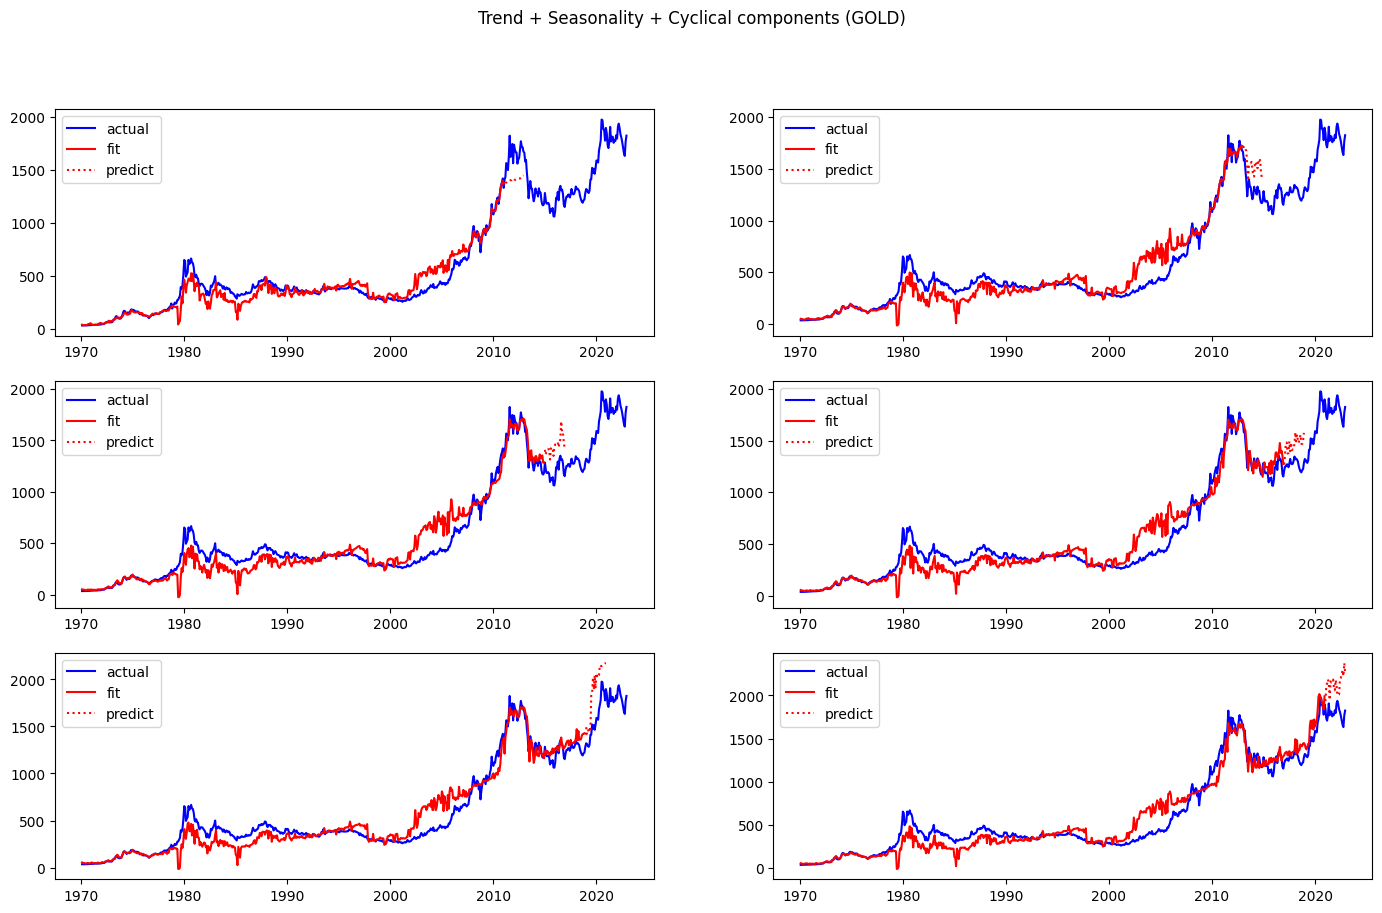

,mae,rmse,mape,me,mpe,corr
mean,258.802796,279.389106,0.178237,185.589255,0.134475,0.430122
std,59.472442,67.834961,0.029750,205.429663,0.130910,0.510808


In [30]:
from sklearn.ensemble import GradientBoostingRegressor

def make_lags(df, lags):
    res = df.copy()
    old_cols = df.columns
    for i in range(1, lags + 1):
        for col in old_cols:
            res[f"{col}_lag_{i}"] = res[col].shift(i)
    return res.drop(old_cols, axis=1)

lags = 1

X_lags = make_lags(y, lags=lags)
X_lags = X_lags.fillna(0.0)

target = "target266" # Let's continue using Gold
y = df[[target]].dropna()

# CV with 6 splits, each test set is 2-years long
tscv = TimeSeriesSplit(n_splits=6, test_size=24)

# Prepare our plot
fig = plt.figure(figsize=(17,10))
fig.suptitle("Trend + Seasonality + Cyclical components (GOLD)")
subplot_idx = 1

# let's store a list of predictions and tests to analyse performance later
y_hat_list = []
y_test_list = []

for i, (train_index, test_index) in enumerate(tscv.split(y)):
    
    X_train, X_test = X_lags.iloc[train_index, :], X_lags.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    y_residuals = y_train - pd.DataFrame(y_fit_trend_list[i], index=y_train.index, columns=y_train.columns)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_residuals.values.ravel())
    
    y_hat = model.predict(X_test) + y_hat_trend_list[i]
       
    # Store prediction and test to analyse performance later
    y_hat_list.append(y_hat)
    y_test_list.append(y_test.iloc[:,0])
        
    prediction_subplot(y, y_train, y_test, model.predict(X_train) + y_fit_trend_list[i], \
                       y_hat, 3, 2, subplot_idx)
    subplot_idx += 1
    
plt.show()
cv_metrics(y_hat_list, y_test_list).agg(["mean","std"])

This is what we can get using only endogenous features, let's try to add exogenous features to our cycle fitting step to further improve the model predictive power.

We also lag these features with the same lags steps as the target.

We need to also retrain the model for trend & seasonality components because by adding exogenous features we have to remove nans and doing so reduces also the data points we have available for y.

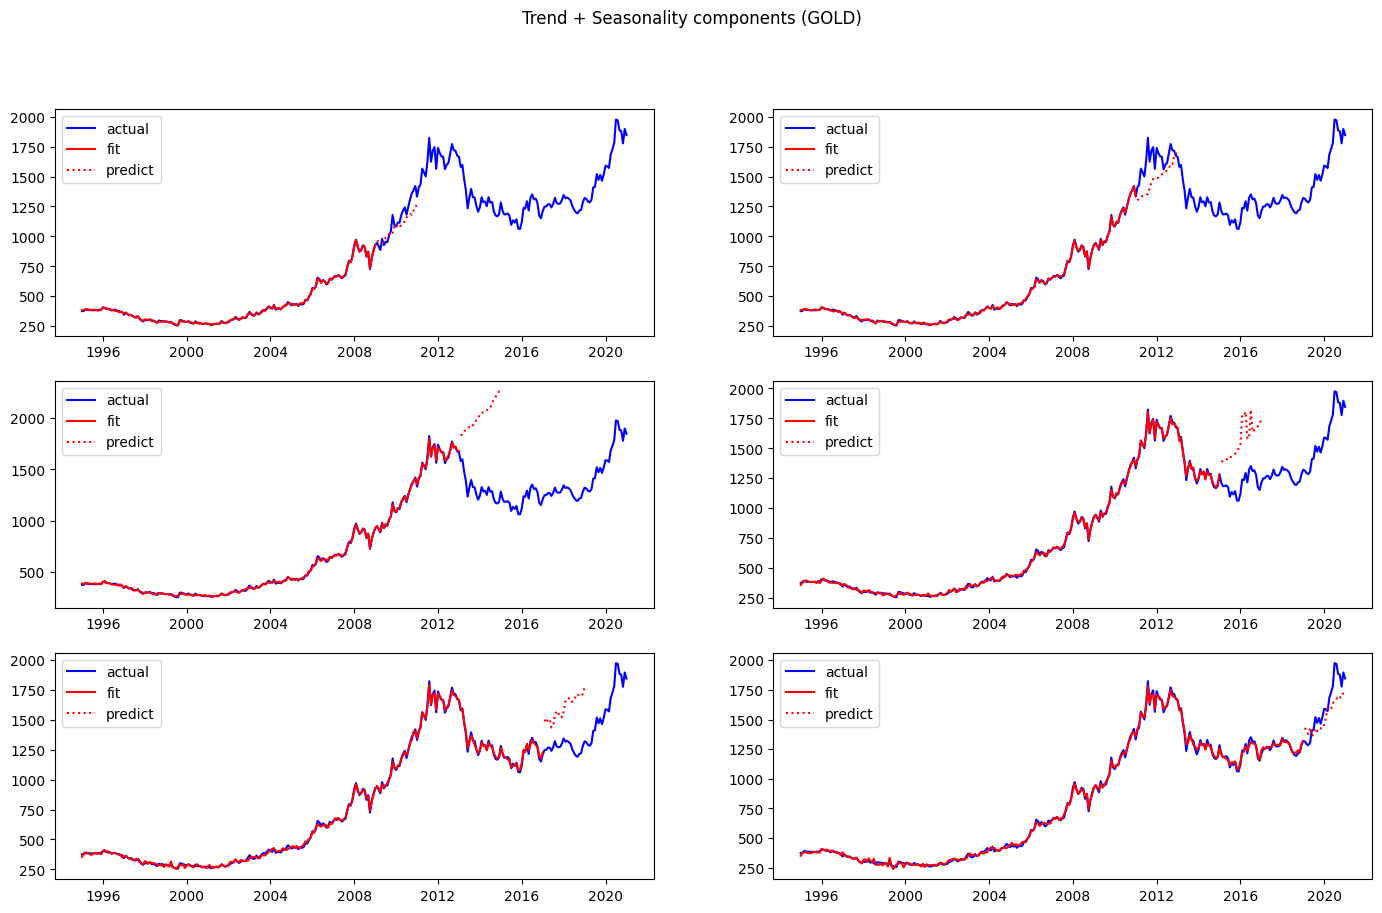

,mae,rmse,mape,me,mpe,corr
mean,296.065852,319.126076,0.228135,189.926084,0.161508,0.363247
std,240.469609,244.373616,0.196920,342.657968,0.262182,0.649580


In [31]:
lags = 1

X = get_X(df, feature_columns)

target = "target266" # Let's continue using Gold

y = df[[target]].dropna()

y, X = y.align(X, join="inner", axis=0)

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=2,
    drop=True,
    seasonal=True,
)
X_dp = dp.in_sample()

X_lags = make_lags(y, lags=lags)
X_lags = pd.concat([X_lags, make_lags(X, lags=lags)], axis=1)
X_lags = X_lags.fillna(0.0)

# CV with 6 splits, each test set is 2-years long
tscv = TimeSeriesSplit(n_splits=6, test_size=24)

# Prepare our plot
fig = plt.figure(figsize=(17,10))
fig.suptitle("Trend + Seasonality components (GOLD)")
subplot_idx = 1

# let's store a list of predictions and tests to analyse performance later
y_hat_list = []
y_test_list = []

for i, (train_index, test_index) in enumerate(tscv.split(y)):
    
    # Fit trend and seasonality
    X_train, X_test = X_dp.iloc[train_index, :], X_dp.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_fit = pd.DataFrame(model.predict(X_train), index=y_train.index, columns=y_train.columns) 
    y_hat = pd.DataFrame(model.predict(X_test), index=y_test.index, columns=y_test.columns) 
    
    # Fit cyclical on residuals (with exogenous features)
    X_train, X_test = X_lags.iloc[train_index, :], X_lags.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    y_residuals = y_train - pd.DataFrame(y_fit, index=y_train.index, columns=y_train.columns)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_residuals.values.ravel())
    
    y_fit += pd.DataFrame(model.predict(X_train), index=y_train.index, columns=y_train.columns) 
    y_hat += pd.DataFrame(model.predict(X_test), index=y_test.index, columns=y_test.columns) 
       
    # Store prediction and test to analyse performance later
    y_hat_list.append(y_hat.iloc[:,0])
    y_test_list.append(y_test.iloc[:,0])
        
    prediction_subplot(y, y_train, y_test, y_fit, y_hat, 3, 2, subplot_idx)
    subplot_idx += 1
    
plt.show()
cv_metrics(y_hat_list, y_test_list).agg(["mean","std"])

## Conclusion
None of the model we created show any particularly good promise.

Let's continue on the next phase to see how we can deploy all we have seen in a production-like environment.

For the sake of this project we will use the hybrid model with exogenous features in the Deployment step.

[Go to Deployment](deployment.ipynb)